# Decision Tree

### 1. Set up spark context and SparkSession

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Decision Tree classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### 2. Load dataset

In [2]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("../data/WineData2.csv",header=True);

In [3]:
df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [4]:
# Convert to float format
def string_to_float(x):
    return float(x)

# 
def condition(r):
    if (0<= r <= 4):
        label = "low" 
    elif(4< r <= 6):
        label = "medium"
    else: 
        label = "high" 
    return label

In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

In [6]:
df = df.withColumn("quality", quality_udf("quality"))

In [7]:
df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free: double (nullable = true)
 |-- total: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



### 3. Convert the data to dense vector

In [9]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

### 4. Transform the dataset to DataFrame

In [11]:
transformed = transData(df)

In [12]:
transformed.show(3)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
+--------------------+------+
only showing top 3 rows



In [13]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)

In [14]:
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [15]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed) 

In [16]:
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



### 5. Split the data to training and test data sets

In [17]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

### 6. Fit Decision Tree Classification Model

In [18]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [19]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [20]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

In [21]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [22]:
from pyspark.ml.linalg import SparseVector, DenseVector
model.stages[-2].featureImportances

SparseVector(11, {0: 0.1019, 1: 0.0848, 2: 0.1658, 3: 0.0921, 4: 0.0223, 5: 0.0301, 6: 0.082, 7: 0.0476, 9: 0.0586, 10: 0.3147})

### 7. Make predictions

In [23]:
# Make predictions.
predictions = model.transform(testData)

In [24]:
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.6,0.52,0.15,2....|   low|        medium|
|[4.7,0.6,0.17,2.3...|medium|          high|
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.4,0.5,4.3,...|medium|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [25]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)
 |-- indexedLabel: double (nullable = true)
 |-- indexedFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)
 |-- predictedLabel: string (nullable = true)



### 8. Evaluation

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.161392
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_46a499f46040d827337c) of depth 5 with 57 nodes


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['medium', 'high', 'low']

In [29]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[495,  21,   1],
       [ 51,  35,   0],
       [ 29,   0,   0]])

Confusion matrix, without normalization
[[495  21   1]
 [ 51  35   0]
 [ 29   0   0]]


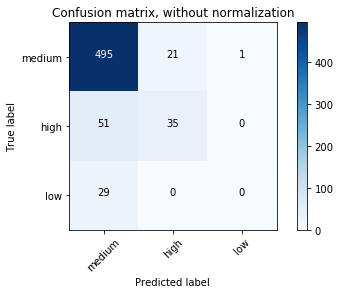

In [30]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [31]:
predictions.select("predictedLabel").filter(predictions.predictedLabel=='low').count()

1

Normalized confusion matrix
[[ 0.95744681  0.04061896  0.00193424]
 [ 0.59302326  0.40697674  0.        ]
 [ 1.          0.          0.        ]]


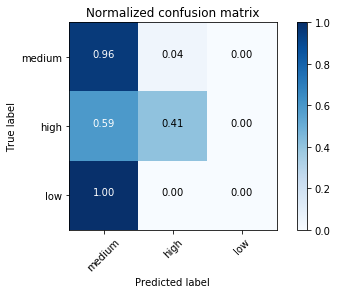

In [32]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 9. Cross-Validation

In [33]:
# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

In [34]:
# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

In [35]:
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [36]:
# Train model.  This also runs the indexers.
dTree_model = crossval.fit(transformed)

#### Fetch best model

In [37]:
# Fetch best model
tree_model = dTree_model.bestModel
tree_model

PipelineModel_486c86c1942e5ce0e38a

In [38]:
# Make predictions.
predictions = tree_model.transform(transformed)
predictions_test = tree_model.transform(testData)

In [39]:
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[7.4,0.7,0.0,1.9,...|medium|        medium|
|[7.8,0.88,0.0,2.6...|medium|        medium|
|[7.8,0.76,0.04,2....|medium|        medium|
|[11.2,0.28,0.56,1...|medium|        medium|
|[7.4,0.7,0.0,1.9,...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [40]:
evaluator.evaluate(predictions)

0.8717775347558855

In [41]:
evaluator.evaluate(predictions_test)

0.8680370773122209